# Human Activity Recognition Project


## Part 1. Data pre processing

Import necessary libraries

In [12]:
import numpy as np 
import pandas as pd 
from scipy import signal, stats
import matplotlib.pyplot as plt 
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Global Variables
totaldatasets = 19 # Total number of datasets in file

Load datasets

In [2]:
# Returns an individual dataset as a pandas dataframe. 
# requested_dataSet is the number of the selected dataset, from 1 to 19
# If the number is outside the range of 1 to 19, function returns dataset 1
def getDataset(requested_dataSet):
    if requested_dataSet < 1 or requested_dataSet > totaldatasets:
        requested_dataSet = 1
    dataSet = pd.read_csv('daliac/dataset_'+str(requested_dataSet)+'.txt', sep=',', header=None)
    return dataSet

# Returns all datasets as a list of dataframes
def getAllDatasets():
    dataSets = []
    for n in range(1, totaldatasets + 1):
        dataSets.append(getDataset(n))
    return dataSets

dfx = getAllDatasets()

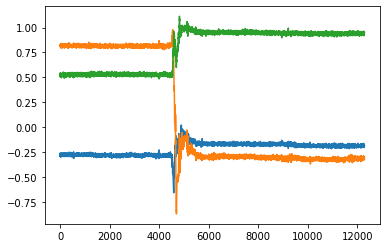

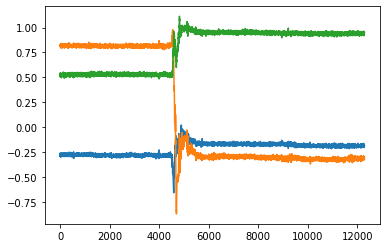

In [3]:

df_sitting = dfx[1][dfx[1][24] == 1].values
    # In this example code, only accelerometer 1 data (column 1 to 3) is used
plt.plot(df_sitting[:, 0:3])
plt.show()

df = getDataset(2)
df_sitting = df[df[24] == 1].values
    # In this example code, only accelerometer 1 data (column 1 to 3) is used
plt.plot(df_sitting[:, 0:3])
plt.show()

In [4]:
# A class for handling data 
class dataSets:
    #Constants for activities
    SITTING = 1
    LYING = 2
    STANDING = 3
    WASHINGDISHES = 4 
    VACUUMING = 5 
    SWEEPING = 6 
    WALKING = 7 
    ASCENDSTAIRS = 8
    DESCENDSTAIRS = 9  
    TREADMILLRUN = 10
    CYCLE50W = 11
    CYCLE100W = 12
    ROPEJUMP = 13
    
    #Constants for sensors.
    WRIST_ACCELEROMETER = 0
    WRIST_GYROSCOPE = 3
    CHEST_ACCELEROMETER = 6
    CHEST_GYROSCOPE = 9
    HIP_ACCELEROMETER = 12
    HIP_GYROSCOPE = 15
    ANKLE_ACCELEROMETER = 18
    ANKLE_GYROSCOPE = 21
    
    def __init__(self, dataSet_collection):
        self.dataSet_collection = dataSet_collection
    
    def getSubjectActivity(self, subject, activity):
        return self.dataSet_collection[subject][self.dataSet_collection[subject][24] == activity].values
    
    def getActivitySensor(self, subject, activity, sensor):
        return self.getSubjectActivity(subject, activity)[:, sensor:sensor+3]
    
HAR_dataset = dataSets(getAllDatasets())

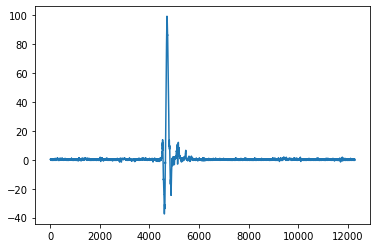

In [5]:
plt.plot(HAR_dataset.getActivitySensor(1, dataSets.SITTING, dataSets.WRIST_GYROSCOPE)[:,1])
plt.show()

983


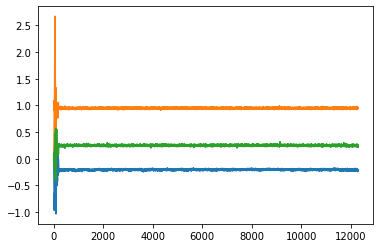

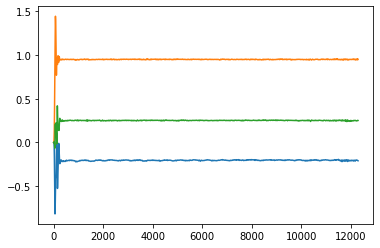

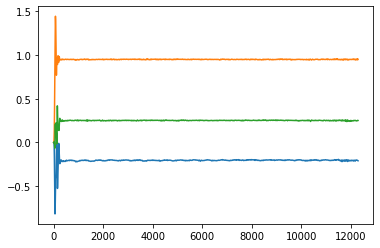

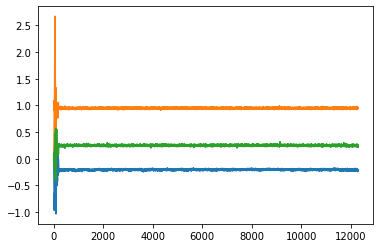

In [6]:
print(math.floor(len(HAR_dataset.getActivitySensor(0, dataSets.SITTING, dataSets.WRIST_ACCELEROMETER)) * 0.08))

plt.plot(HAR_dataset.getActivitySensor(0, dataSets.SITTING, dataSets.WRIST_ACCELEROMETER))
plt.show()

# filters data from a given data set.
# Optional parmeter filter_cutoff
# Optional parameters numerator and denominator allow for use of custom filter.
# Otherwise defaults to lowpass butterworth filter
def remove_noise(data_set, filter_cutoff = None,
                 numerator = signal.butter(4, 0.04, 'low', analog = False)[0],
                 denominator = signal.butter(4, 0.04, 'low', analog = False)[1]):
    for column in range(len(data_set[0][:filter_cutoff])):
        data_set[:, column] = signal.lfilter(numerator, denominator, data_set[:, column])
    return data_set

df = pd.read_csv('daliac/dataset_1.txt', sep=',', header=None)
# Butterworth low-pass filter. You could try different parameters and other filters. 
b, a = signal.butter(4, 0.04, 'low', analog=False)
df_sitting = df[df[24] == 1].values
for i in range(3):
    df_sitting[:,i] = signal.lfilter(b, a, df_sitting[:, i])

plt.plot(df_sitting[:, 0:3])
plt.show()

plt.plot(remove_noise(data_set = HAR_dataset.getActivitySensor(0, dataSets.SITTING, dataSets.WRIST_ACCELEROMETER)))
plt.show()

plt.plot(HAR_dataset.getActivitySensor(0, dataSets.SITTING, dataSets.WRIST_ACCELEROMETER))
plt.show()

In [7]:
def feature_engineering_example():
    training = np.empty(shape=(0, 10))
    testing = np.empty(shape=(0, 10))
    # deal with each dataset file
    for i in range(19):
        df = pd.read_csv('daliac/dataset_' + str(i + 1) + '.txt', sep=',', header=None)
        print('deal with dataset ' + str(i + 1))
        for c in range(1, 14):
            activity_data = df[df[24] == c].values
            b, a = signal.butter(4, 0.04, 'low', analog=False)
            for j in range(24):
                activity_data[:, j] = signal.lfilter(b, a, activity_data[:, j])
            
            datat_len = len(activity_data)
            training_len = math.floor(datat_len * 0.8)
            training_data = activity_data[:training_len, :]
            testing_data = activity_data[training_len:, :]

# data segementation: for time series data, we need to segment the whole time series, and then extract features 
# from each period of time to represent the raw data. In this example code, we define each period of time contains 
# 1000 data points. Each period of time contains different data points. You may consider overlap segmentation, 
# which means consecutive two segmentation share a part of data points, to get more feature samples.
            training_sample_number = training_len // 1000 + 1
            testing_sample_number = (datat_len - training_len) // 1000 + 1

            for s in range(training_sample_number):
                if s < training_sample_number - 1:
                    sample_data = training_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = training_data[1000*s:, :]
# in this example code, only three accelerometer data in wrist sensor is used to extract three simple features: 
# min, max, and mean value in a period of time. Finally we get 9 features and 1 label to construct feature dataset. 
# You may consider all sensors' data and extract more

                feature_sample = []
                for i in range(3):
                    feature_sample.append(np.min(sample_data[:, i]))
                    feature_sample.append(np.max(sample_data[:, i]))
                    feature_sample.append(np.mean(sample_data[:, i]))
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                training = np.concatenate((training, feature_sample), axis=0)
            
            for s in range(testing_sample_number):
                if s < training_sample_number - 1:
                    sample_data = testing_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = testing_data[1000*s:, :]

                feature_sample = []
                for i in range(3):
                    feature_sample.append(np.min(sample_data[:, i]))
                    feature_sample.append(np.max(sample_data[:, i]))
                    feature_sample.append(np.mean(sample_data[:, i]))
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                testing = np.concatenate((testing, feature_sample), axis=0)

    df_training = pd.DataFrame(training)
    df_testing = pd.DataFrame(testing)
    df_training.to_csv('training_data.csv', index=None, header=None)
    df_testing.to_csv('testing_data.csv', index=None, header=None)

feature_engineering_example()

deal with dataset 1
deal with dataset 2
deal with dataset 3
deal with dataset 4
deal with dataset 5
deal with dataset 6
deal with dataset 7
deal with dataset 8
deal with dataset 9
deal with dataset 10
deal with dataset 11
deal with dataset 12
deal with dataset 13
deal with dataset 14
deal with dataset 15
deal with dataset 16
deal with dataset 17
deal with dataset 18
deal with dataset 19


In [14]:
def feature_engineering_example(dataset_collection):
    training = np.empty(shape=(0, 19))
    testing = np.empty(shape=(0, 19))
    # deal with each dataset file
    for participant in range(totaldatasets):
        for activity in range(1, 14):
            activity_data = remove_noise(dataset_collection.getSubjectActivity(participant, activity), filter_cutoff = 24)
            
            datat_len = len(activity_data)
            training_len = math.floor(datat_len * 0.8)
            training_data = activity_data[:training_len, :]
            testing_data = activity_data[training_len:, :]

# data segementation: for time series data, we need to segment the whole time series, and then extract features 
# from each period of time to represent the raw data. In this example code, we define each period of time contains 
# 1000 data points. Each period of time contains different data points. You may consider overlap segmentation, 
# which means consecutive two segmentation share a part of data points, to get more feature samples.
            training_sample_number = training_len // 1000 + 1
            testing_sample_number = (datat_len - training_len) // 1000 + 1

            for s in range(training_sample_number):
                if s < training_sample_number - 1:
                    sample_data = training_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = training_data[1000*s:, :]
# in this example code, only three accelerometer data in wrist sensor is used to extract three simple features: 
# min, max, and mean value in a period of time. Finally we get 9 features and 1 label to construct feature dataset. 
# You may consider all sensors' data and extract more

                feature_sample = []
                for i in range(3):
                    feature_sample.append(np.min(sample_data[:, i]))
                    feature_sample.append(np.max(sample_data[:, i]))
                    feature_sample.append(np.mean(sample_data[:, i]))
                    feature_sample.append(np.std(sample_data[:, i]))
                    feature_sample.append(stats.skew(sample_data[:, i]))
                    feature_sample.append(stats.kurtosis(sample_data[:, i]))
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                training = np.concatenate((training, feature_sample), axis=0)
            
            for s in range(testing_sample_number):
                if s < training_sample_number - 1:
                    sample_data = testing_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = testing_data[1000*s:, :]

                feature_sample = []
                for i in range(3):
                    feature_sample.append(np.min(sample_data[:, i]))
                    feature_sample.append(np.max(sample_data[:, i]))
                    feature_sample.append(np.mean(sample_data[:, i]))
                    feature_sample.append(np.std(sample_data[:, i]))
                    feature_sample.append(stats.skew(sample_data[:, i]))
                    feature_sample.append(stats.kurtosis(sample_data[:, i]))
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                testing = np.concatenate((testing, feature_sample), axis=0)

    df_training = pd.DataFrame(training)
    df_testing = pd.DataFrame(testing)
    df_training.to_csv('training_data.csv', index=None, header=None)
    df_testing.to_csv('testing_data.csv', index=None, header=None)

feature_engineering_example(HAR_dataset)

In [9]:
activity_data = remove_noise(HAR_dataset.getSubjectActivity(0, dataSets.SITTING), filter_cutoff = 24)
            
datat_len = len(activity_data)
training_len = math.floor(datat_len * 0.8)
training_data = activity_data[:training_len, :]
testing_data = activity_data[training_len:, :]

print("datat_len: "+str(datat_len))
print("training_len: "+str(training_len))

training_sample_number = training_len // 1000 + 1
testing_sample_number = (datat_len - training_len) // 1000 + 1
print("training_sample_number: "+str(training_sample_number))
print("testing_sample_number: "+str(testing_sample_number))

datat_len: 12290
training_len: 9832
training_sample_number: 10
testing_sample_number: 3
